In [1]:
import gym
import numpy as np

In [2]:
env = gym.make("Taxi-v3")
env.reset()
env.render()
iterations = 5000

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [3]:
#state 5*5
env.step(5)

(208, -10, False, {'prob': 1.0})

In [4]:
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


In [5]:
"""
tree backup implementation on the frozen lake
"""
from collections import defaultdict
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

class tree_backup():
    def __init__(self,
                env,gamma,epsilon,alpha, n):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.q = defaultdict(lambda : np.zeros(env.action_space.n))
        self.n = n
    
    def choose_action(self, state):
        epsilon = self.epsilon
        if np.random.random() < epsilon:
            return env.action_space.sample()
        else:
            return np.argmax(self.q[state])
        
    def action_possibility(self, state):
        epsilon = self.epsilon
        P = []
        actions = self.q[state]
        n = env.action_space.n
        for i in range(0,n):
            if i == np.argmax(actions):
                P.append((epsilon/n) + 1 - epsilon)
            else:
                P.append(epsilon/n)
        return P
        
    def run_episode(self):
        epsilon = self.epsilon
        alpha = self.alpha
        episode_return = 0
        
        
        # the state, action and reward of each step are saved in an array
        r_buffer = []
        s_buffer = []
        a_buffer = []
        
        #n-steps to calculate the q-value
        n = self.n
        
        #start with 0 and no more than 1000
        t = 0
        T = 1000
        
        #initialized the environment and buffer with starting state
        state = self.env.reset()
        action = self.choose_action(state)
        
        s_buffer.insert(t,state)
        a_buffer.insert(t,action)
        r_buffer.insert(t,0)
        
        while True:
            if t < T:
            #run a step here; move the run_step() function to here instead of a separated function
                state, reward, done, _ = self.env.step(action)            
                r_buffer.insert(t+1,reward)
                s_buffer.insert(t+1, state)

            #store the reward, state and action
                episode_return += reward
             #if terminated, then T = t + 1
                if done:
                    T = t + 1
                else:
                    action = self.choose_action(state)
                    a_buffer.insert(t+1, action)
            # tao is the n-steps traceback
            tao = t + 1 - n
            G = 0
            if tao >= 0:
                #terminate
                if (t+1) >= T:
                    G = r_buffer[T]
                else:
                    P = self.action_possibility(s_buffer[t+1])
                    "here is the sum of probability * action value"
                    V = P * self.q[s_buffer[t+1]]
                    G = r_buffer[t+1] + self.gamma * sum(V)
                    k = min(t,T-1)
                    while k > tao:
                        k_state = s_buffer[k]
                        k_action = a_buffer[k]
                        k_reward = r_buffer[k]
                        
                        P = self.action_possibility(s_buffer[k])
                        V1 = 0
                        for i in range(0,4):
                            if i != k_action:
                                V1 += P[i] * self.q[k_state][i]
                        V2 = P[k_action] * G
                        G = r_buffer[k] + self.gamma * V1 + self.gamma * V2
                        k -= 1
                tao_state = s_buffer[tao]
                tao_action = a_buffer[tao]
                self.q[tao_state][tao_action] += self.alpha * (G - self.q[tao_state][tao_action])
            t = t + 1
            if tao == T-1:
                break
           
        return episode_return
    
    def learn_task(self, n):
        returns = []
        for i in tqdm(range(n)):
            episode_return = self.run_episode()
            returns.append(episode_return)
        #print(self.q)
        return returns

    

In [6]:
"""
Then try to train the agent with n = 1,2,4,8,16
"""
env.reset()  
agent1 = tree_backup(env, gamma = 0.9, epsilon = 0.1,
           alpha = 0.1,n=1)
n1 = agent1.learn_task(iterations)

100%|██████████████████████████████████████| 5000/5000 [00:05<00:00, 941.95it/s]


In [7]:
env.reset()  
agent2 = tree_backup(env, gamma = 0.9, epsilon = 0.1,
           alpha = 0.1,n=2)
n2 = agent2.learn_task(iterations)

100%|██████████████████████████████████████| 5000/5000 [00:06<00:00, 833.17it/s]


In [8]:
env.reset()  
agent4 = tree_backup(env, gamma = 0.9, epsilon = 0.1,
           alpha = 0.1,n=4)
n4 = agent4.learn_task(iterations)

100%|██████████████████████████████████████| 5000/5000 [00:08<00:00, 571.16it/s]


In [9]:
env.reset()  
agent8 = tree_backup(env, gamma = 0.9, epsilon = 0.1,
           alpha = 0.1,n=8)
n8 = agent8.learn_task(iterations)

100%|██████████████████████████████████████| 5000/5000 [00:47<00:00, 104.30it/s]


In [10]:
env.reset()  
agent16 = tree_backup(env, gamma = 0.9, epsilon = 0.1,
           alpha = 0.1,n=16)
n16 = agent16.learn_task(iterations)

100%|██████████████████████████████████████| 5000/5000 [00:45<00:00, 110.66it/s]


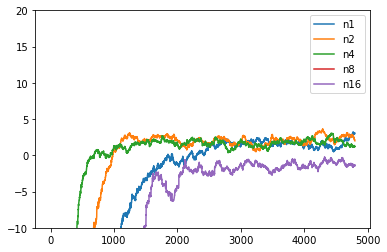

In [11]:
from matplotlib import pyplot as plt
from scipy.interpolate import pchip
import pandas as pd

def moving_average(a,n):
    N=len(a)
    return np.array([np.mean(a[i:i+n]) for i in np.arange(0,N-n+1)])

window_size = 200

n1_smooth = moving_average(n1, window_size)
n2_smooth = moving_average(n2, window_size)
n4_smooth = moving_average(n4, window_size)
n8_smooth = moving_average(n8, window_size)
n16_smooth = moving_average(n16,window_size)

plt.ylim([-10,20])
plt.plot(n1_smooth,label="n1")
plt.plot(n2_smooth,label="n2")
plt.plot(n4_smooth,label="n4")
plt.plot(n8_smooth,label="n8")
plt.plot(n16_smooth,label="n16")
plt.legend()
plt.rcParams["figure.figsize"] = [16,12]
plt.show()

In [12]:
"""The result demonstrate when n = 4 it can converage fastest in the taxi task"""

'The result demonstrate when n = 4 it can converage fastest in the taxi task'